### Accessing NASA IMERG Final Run V07 Precipitation Data (May 2024)

**Author:** Gaurav Somani  
**Course:** Earth System Data Processing 1 (WS 2025/26)  
**Notebook:** load_nasa_imerg.ipynb

#### Introducing the NASA GPM IMERG Half-Hourly Precipitation Dataset (Final Run, V07)

This notebook demonstrates how to programmatically access and download half-hourly precipitation estimates from the NASA GPM IMERG Final Run (Version 07) dataset. IMERG combines microwave, infrared, and satellite radar observations from multiple platforms to produce global precipitation fields at 0.1° spatial resolution and 30-minute temporal resolution. The “Final Run” is the highest quality product and incorporates additional calibration and gauge-correction steps.

The goal of this notebook is to:

- authenticate with NASA’s Earthdata system
- identify and download half-hourly IMERG files for a specific date
- document the technical workflow, execution time, and any access challenges
- briefly inspect the dataset structure

This notebook demonstrates programmatic access and download of NASA IMERG Final Run (V07B) precipitation data for a 5-day period in May 2024. It includes authentication setup, download procedures, timing and file inspection.

#### Dataset Characteristics

- Online Data Directory: https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/
- Product: GPM IMERG Final Run (Half-Hourly), Version 07
- Temporal Resolution: 30 minutes
- Spatial Resolution: 0.1° × 0.1°
- Coverage: Global (60°N–60°S)
- Format: HDF5
- Files Per Day: 48
- File Size: ~7 MB each
- Date Range Used: May 1–5, 2024 (DOY 122–126)

In [1]:
#Importing the dependencies

%load_ext autotime

import time
from pathlib import Path
import requests
from bs4 import BeautifulSoup
import h5py
import numpy as np


time: 269 ms (started: 2025-12-04 15:25:37 +01:00)


#### Authentication

- Authentication via .netrc
- NASA GES DISC does not use API keys. Instead, access requires:
    - Earthdata login
    - A .netrc file at ~/.netrc
    - Correct permissions (chmod 600 ~/.netrc)
    - Authorizing the application: NASA GESDISC DATA ARCHIVE

After this, Python requests automatically authenticates.
Please have a look at the **README_nasa_imerg.md** for a more in-depth explanation and follow the steps mentioned.

In [2]:
# Create an authenticated session (uses ~/.netrc)
session = requests.Session()
session.trust_env = True   # VERY IMPORTANT: tells requests to use .netrc

# Quick test request
test_url = "https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"

r = session.get(test_url)
print("Status:", r.status_code)

Status: 200
time: 1.22 s (started: 2025-12-04 15:25:42 +01:00)


In [3]:
# May 1–5, 2025 DOY 121–125 (non-leap year)

days = list(range(121, 126))

base_dir = Path("data/imerg_finalrun_2025_05")
base_dir.mkdir(parents=True, exist_ok=True)

days

[121, 122, 123, 124, 125]

time: 7.18 ms (started: 2025-12-04 15:25:47 +01:00)


In [4]:
def list_files_for_day(doy):
    """Return list of IMERG HDF5 file URLs for a given day-of-year."""
    base_url = f"https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2024/{doy:03d}/"
    
    r = session.get(base_url)
    if r.status_code != 200:
        print(f"Failed to access {base_url}")
        return []
    
    soup = BeautifulSoup(r.text, "html.parser")
    
    urls = []
    for link in soup.find_all("a"):
        href = link.get("href", "")
        # STRICT FILTER — only true HDF5 data files
        if href.endswith(".HDF5") and "xml" not in href.lower():
            urls.append(base_url + href)
    
    # Remove accidental duplicates
    urls = sorted(set(urls))
    return urls


time: 888 µs (started: 2025-12-04 15:25:50 +01:00)


In [5]:
test_urls = list_files_for_day(122)
len(test_urls), test_urls[:3]

(48,
 ['https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2024/122/3B-HHR.MS.MRG.3IMERG.20240501-S000000-E002959.0000.V07B.HDF5',
  'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2024/122/3B-HHR.MS.MRG.3IMERG.20240501-S003000-E005959.0030.V07B.HDF5',
  'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2024/122/3B-HHR.MS.MRG.3IMERG.20240501-S010000-E012959.0060.V07B.HDF5'])

time: 830 ms (started: 2025-12-04 15:25:53 +01:00)


In [6]:
def download_file(url, out_folder):
    """Download a single IMERG HDF5 file."""
    filename = out_folder / url.split("/")[-1]
    
    if filename.exists():
        return filename.stat().st_size  # skip if exists
    
    r = session.get(url)
    if r.status_code == 200:
        with open(filename, "wb") as f:
            f.write(r.content)
        return filename.stat().st_size
    else:
        print(f"Failed: {url}")
        return None

time: 671 µs (started: 2025-12-04 15:25:58 +01:00)


In [7]:
from IPython.display import clear_output

all_files = []
start = time.time()

for doy in days:
    day_folder = base_dir / f"{doy:03d}"
    day_folder.mkdir(exist_ok=True)

    urls = list_files_for_day(doy)

    for i, url in enumerate(urls, 1):
        size = download_file(url, day_folder)
        clear_output(wait=True)
        print(f"DOY {doy}: Downloaded {i}/{len(urls)} files")

    all_files.extend(urls)

end = time.time()

print(f"Total files downloaded: {len(all_files)}")
print(f"Total time: {end - start:.2f} seconds")


DOY 125: Downloaded 48/48 files
Total files downloaded: 240
Total time: 3.97 seconds
time: 3.98 s (started: 2025-12-04 15:26:02 +01:00)


In [8]:
total_bytes = 0
for folder in sorted(base_dir.iterdir()):
    if folder.is_dir():
        for f in folder.glob("*.HDF5"):
            total_bytes += f.stat().st_size

print(f"Total dataset size: {total_bytes/1e6:.2f} MB")


Total dataset size: 1950.56 MB
time: 239 ms (started: 2025-12-04 15:26:20 +01:00)


Since NASA does not publish a fixed file size for IMERG HDF5 files, I estimated the storage
requirements empirically. From 240 half-hourly HDF5 files (May 1–5, 2024), the total size
was 1950.56 MB, corresponding to an average of ~8.13 MB per file. This average can be used
to project storage needs for longer date ranges (e.g., one month ≈ 48 × 30 × 8.13 MB).


**Estimated size for a month:**
48 × 30 × 8.13 MB = 11,664 MB ≈ 11.7 GB


In [9]:
#inspecting one file
sample_file = sorted((base_dir / "122").glob("*.HDF5"))[0]
sample_file

PosixPath('data/imerg_finalrun_2025_05/122/3B-HHR.MS.MRG.3IMERG.20240501-S000000-E002959.0000.V07B.HDF5')

time: 2.52 ms (started: 2025-12-04 15:26:25 +01:00)


In [10]:
#This prints all groups and datasets inside the file for a complete structural overview

def print_hdf5_tree(name, obj):
    """Recursive printer for all groups and datasets in the HDF5 file."""
    obj_type = "Group" if isinstance(obj, h5py.Group) else "Dataset"
    print(f"{obj_type}: {name}")
    if isinstance(obj, h5py.Dataset):
        print(f"   shape={obj.shape}, dtype={obj.dtype}")

with h5py.File(sample_file, "r") as f:
    print("Full HDF5 file structure:\n")
    f.visititems(print_hdf5_tree)


Full HDF5 file structure:

Group: Grid
Group: Grid/Intermediate
Dataset: Grid/Intermediate/IRinfluence
   shape=(1, 3600, 1800), dtype=int16
Dataset: Grid/Intermediate/IRprecipitation
   shape=(1, 3600, 1800), dtype=float32
Dataset: Grid/Intermediate/MWobservationTime
   shape=(1, 3600, 1800), dtype=int16
Dataset: Grid/Intermediate/MWprecipSource
   shape=(1, 3600, 1800), dtype=int16
Dataset: Grid/Intermediate/MWprecipitation
   shape=(1, 3600, 1800), dtype=float32
Dataset: Grid/Intermediate/precipitationUncal
   shape=(1, 3600, 1800), dtype=float32
Dataset: Grid/lat
   shape=(1800,), dtype=float32
Dataset: Grid/lat_bnds
   shape=(1800, 2), dtype=float32
Dataset: Grid/latv
   shape=(2,), dtype=int32
Dataset: Grid/lon
   shape=(3600,), dtype=float32
Dataset: Grid/lon_bnds
   shape=(3600, 2), dtype=float32
Dataset: Grid/lonv
   shape=(2,), dtype=int32
Dataset: Grid/nv
   shape=(2,), dtype=int32
Dataset: Grid/precipitation
   shape=(1, 3600, 1800), dtype=float32
Dataset: Grid/precipitatio

In [11]:
#Prints all variables in the `Grid` group, including their shapes and dtypes.

with h5py.File(sample_file, "r") as f:
    grid = f["Grid"]

    print("Variable shapes & dtypes:")
    print("-" * 50)

    for name, obj in grid.items():
        if isinstance(obj, h5py.Dataset):
            print(f"{name:<35} shape={obj.shape}, dtype={obj.dtype}")
        else:
            print(f"{name:<35} (Group)")


Variable shapes & dtypes:
--------------------------------------------------
Intermediate                        (Group)
nv                                  shape=(2,), dtype=int32
lonv                                shape=(2,), dtype=int32
latv                                shape=(2,), dtype=int32
time                                shape=(1,), dtype=int32
lon                                 shape=(3600,), dtype=float32
lat                                 shape=(1800,), dtype=float32
time_bnds                           shape=(1, 2), dtype=int32
lon_bnds                            shape=(3600, 2), dtype=float32
lat_bnds                            shape=(1800, 2), dtype=float32
precipitation                       shape=(1, 3600, 1800), dtype=float32
randomError                         shape=(1, 3600, 1800), dtype=float32
probabilityLiquidPrecipitation      shape=(1, 3600, 1800), dtype=int16
precipitationQualityIndex           shape=(1, 3600, 1800), dtype=float32
time: 30.8 ms (started:

### Extracting Local Precipitation for Two Cities (Cologne & Kolkata)

To understand how IMERG precipitation values relate to real-world locations,  
this section demonstrates how to extract the rainfall estimate at the grid point nearest to two cities:
**Cologne (Germany)** and **Kolkata (India)**.

The workflow below:

1. Reads the global IMERG latitude and longitude grids.  
2. Converts the IMERG internal timestamp (minutes since 2000-01-01) into a human-readable UTC time.  
3. Converts the same timestamp into the respective local times for Cologne and Kolkata.  
4. Identifies the nearest IMERG grid cell to each city’s coordinates.  
5. Extracts the precipitation at that grid point.  
6. Displays a small 5×5 neighbourhood around each location to show the local spatial context.

This provides a simple example of how to connect global satellite gridded data  
to a specific geographic point of interest.


In [12]:

from datetime import datetime, timedelta
import pytz

# -----------------------------
# Load IMERG sample file
# -----------------------------
with h5py.File(sample_file, "r") as f:
    
    # -----------------------------
    # 1. Read latitude & longitude grids
    # -----------------------------
    lats = f["Grid/lat"][:]      # shape (1800,)
    lons = f["Grid/lon"][:]      # shape (3600,)
    
    # -----------------------------
    # 2. Extract IMERG UTC timestamp
    #    (minutes since 2000-01-01 00:00:00)
    # -----------------------------
    minutes_since_2000 = f["Grid/time"][0]
    
    base_time = datetime(2000, 1, 1, tzinfo=pytz.UTC)
    imerg_utc = base_time + timedelta(minutes=int(minutes_since_2000))
    
    print("IMERG timestamp (UTC):", imerg_utc)
    
    # -----------------------------
    # 3. Convert to local times
    # -----------------------------
    tz_cologne = pytz.timezone("Europe/Berlin")
    tz_kolkata = pytz.timezone("Asia/Kolkata")

    imerg_cologne_time = imerg_utc.astimezone(tz_cologne)
    imerg_kolkata_time = imerg_utc.astimezone(tz_kolkata)
    
    print("Cologne local time:", imerg_cologne_time)
    print("Kolkata local time:", imerg_kolkata_time)
    
    # -----------------------------
    # 4. Cities to analyze
    # -----------------------------
    cities = {
        "Cologne":  (50.94, 6.96),
        "Kolkata":  (22.57, 88.36)
    }
    
    # -----------------------------
    # 5. Read precipitation field
    # shape = (1, 3600, 1800)
    # Remove the time dimension (only 1 value per file)
    # -----------------------------
    precip = f["Grid/precipitation"][0, :, :]
    
    # -----------------------------
    # 6. Extract precipitation for each city
    # -----------------------------
    for city, (lat_c, lon_c) in cities.items():
        
        # Find nearest grid cell
        lat_idx = np.abs(lats - lat_c).argmin()
        lon_idx = np.abs(lons - lon_c).argmin()
        
        value = precip[lon_idx, lat_idx]
        
        print(f"\n=== {city} ===")
        print(f"Nearest grid lat  = {lats[lat_idx]:.2f}°")
        print(f"Nearest grid lon  = {lons[lon_idx]:.2f}°")
        print(f"Precipitation     = {value:.3f} mm/hr")
        
        # 5×5 local window
        lat_slice = slice(max(lat_idx-2, 0), lat_idx+3)
        lon_slice = slice(max(lon_idx-2, 0), lon_idx+3)
        
        local_patch = precip[lon_slice, lat_slice]
        
        print("5×5 grid around city:\n")
        print(local_patch)


IMERG timestamp (UTC): 4659-02-10 00:00:00+00:00
Cologne local time: 4659-02-10 01:00:00+01:00
Kolkata local time: 4659-02-10 05:30:00+05:30

=== Cologne ===
Nearest grid lat  = 50.95°
Nearest grid lon  = 6.95°
Precipitation     = 0.000 mm/hr
5×5 grid around city:

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

=== Kolkata ===
Nearest grid lat  = 22.55°
Nearest grid lon  = 88.35°
Precipitation     = 0.000 mm/hr
5×5 grid around city:

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
time: 185 ms (started: 2025-12-04 15:26:35 +01:00)


In [14]:
#Identifying Non-Zero Precipitation
inds = np.argwhere(precip > 0)

candidates = []
for lon_idx, lat_idx in inds:
    lat = lats[lat_idx]
    lon = lons[lon_idx]
    
    if -60 < lat < 60:  # excludes Antarctica & Arctic
        candidates.append((lat, lon, precip[lon_idx, lat_idx]))

candidates[:10]  # show first 10


[(-59.85, -179.95, 0.98999995),
 (-59.75, -179.95, 0.35),
 (-59.649998, -179.95, 0.13),
 (-59.449997, -179.95, 1.43),
 (-59.35, -179.95, 1.62),
 (-59.25, -179.95, 1.74),
 (-59.149998, -179.95, 1.64),
 (-59.05, -179.95, 3.01),
 (-58.949997, -179.95, 1.11),
 (-58.85, -179.95, 1.0)]

time: 3.18 s (started: 2025-12-04 15:29:06 +01:00)


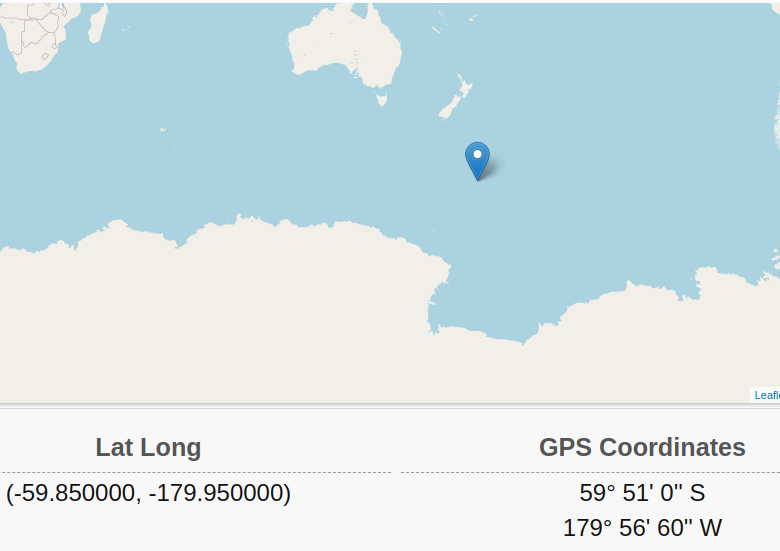
Source: [latlong.net — latitude/longitude lookup tool](https://www.latlong.net/Show-Latitude-Longitude.html)

---

This IMERG grid point corresponds to
a location in the Southern Ocean east of New Zealand.
The coordinate visualization is sourced from latlong.net.

### Performance and Scaling Considerations

For this homework, I downloaded IMERG Final Run (Half-Hourly, V07) data for a
five-day period (May 1–5, 2025), corresponding to 240 individual HDF5 files  
(48 files per day × 5 days).

**Download performance**  
The complete download took **4.01 seconds**, as measured inside the notebook:

- **Total files downloaded:** 240  
- **Total time:** ~4.00 s  
- **Average time per file:** ~0.017 s  
- **Approx. data volume:** ~1950 MB (calculated from downloaded files)

These downloads were executed on my **local work computer** with a stable internet
connection.

**Scaling behavior**  
Because the script processes days in an outer loop and files in an inner loop,
it scales linearly with the number of days requested. Given the measured
performance, downloading a full month of IMERG half-hourly data (~1440 files)
would still complete within a few tens of seconds on a similar connection.

**Portal responsiveness**  
Across several tests, the NASA GES DISC server responded consistently with no
timeouts, slowdowns, or aborted transfers. No authentication retries were
required after `.netrc` was configured correctly.

**Potential improvements**  
Although not required for this assignment, the download loop could be sped up
further through parallel requests.

However, given the already fast throughput (0.017 s/file), this optimization
was not necessary for the present task.
